### 1. Preparing the data

Import the used library for training dataset and connect to Google Drive


In [1]:
from google.colab import drive
drive.mount('Mydrive')

Mounted at Mydrive


In [2]:
import os
import zipfile
from os import listdir
from matplotlib import image
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.constraints import unit_norm
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import top_k_categorical_accuracy

from keras.models import load_model

from PIL import Image
import base64
import io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.0 MB/s 


/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


#### **Unzip the dataset and define few preprocessing steps**

In [3]:
local_zip = '/content/Mydrive/MyDrive/Colab Notebooks/train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

local_zip = '/content/Mydrive/MyDrive/Colab Notebooks/test.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Define a normalization function

In [4]:
IMG_SIZE_ARRAY = (160, 160)
def _normalize_img(img):
    img = tf.image.central_crop(img,0.8)
    img = tf.image.adjust_brightness(img, delta = 0.2)
    img = tf.image.flip_left_right(img)
    img = tf.image.resize(img, IMG_SIZE_ARRAY)
    img = tf.cast(img, tf.float32)/255.   # All images will be rescaled by 1./255
    return (img)

def _normalize_img_1(img):
    img = tf.image.resize(img, IMG_SIZE_ARRAY)
    img = tf.cast(img, tf.float32)/255.   # All images will be rescaled by 1./255
    return (img)

#### **Load the train and test data in a list**
This method will load all the data into memory (RAM) before feeding it into the classifier for training. This is only possible when our dataset is small.


Create array list storing image paths and labels

In [5]:
train_info = '/content/Mydrive/MyDrive/Colab Notebooks/list/train.txt'

with open(train_info) as txt_file:
  lines = [x.strip() for x in txt_file.readlines()]

def TrainImageAndLabel():
  data = []
  for x in lines:
      temp = x.split(' ')
      img_data = image.imread('/tmp/' + temp[0])
      normalized_img = _normalize_img(img_data)
      data.append([normalized_img, int(temp[1])])
  for x in lines:
      temp = x.split(' ')
      img_data = image.imread('/tmp/' + temp[0])
      normalized_img = _normalize_img_1(img_data)
      data.append([normalized_img, int(temp[1])])
  return data

train_data = TrainImageAndLabel()

In [6]:
test_info = '/content/Mydrive/MyDrive/Colab Notebooks/list/groundtruth.txt'

with open(test_info) as txt_file:
  lines = [x.strip() for x in txt_file.readlines()]

def TestImageAndLabel():
  data = []
  for x in lines:
      temp = x.split(' ')
      img_data = image.imread('/tmp/' + temp[0])
      normalized_img = _normalize_img_1(img_data)
      data.append([normalized_img, int(temp[1])])
  return data

test_data = TestImageAndLabel()

In [7]:
x_train = []
y_train = []
for x,y in train_data:
  x_train.append(x)
  y_train.append(y)


In [8]:
x_test = []
y_test = []
for x,y in test_data:
  x_test.append(x)
  y_test.append(y)


In [9]:
# Convert Python List, "train_loaded_images" to numpy Arrays, "X_train"
x_train = np.array(x_train)
# Convert Python List, "test_loaded_images" to numpy Arrays, "X_test"
x_test = np.array(x_test)

# Convert Python List, "Y_train" to numpy Arrays, "Y_train"
y_train = np.array(y_train)
# Convert Python List, "Y_test" to numpy Arrays, "Y_test"
y_test = np.array(y_test)

In [10]:
train_label = np.unique(y_train)
no_classes = train_label.size

In [11]:
def changeLabel():
  i=0;
  label = []
  for temp in train_label:
    label.append([temp,i])
    i += 1
  return label

new_label = changeLabel()

In [12]:
i =0;
for label in y_train:
  for x,y in new_label:
    if(label == x):
      y_train[i] = y
      break
  i += 1

In [13]:
j =0;
for label in y_test:
  for x,y in new_label:
    if(label == x):
      y_test[j] = y
      break
  j += 1

### CNN architecture

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE_ARRAY + (3,)

In [15]:
# Normalization of preprocessing input 

def preprocess_input_mobile_net():
  return tf.keras.applications.mobilenet_v2.preprocess_input

preprocess_input = preprocess_input_mobile_net()

In [16]:
def model_mobile_net():
  return tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
            include_top=False, weights='imagenet')
  
base_model = model_mobile_net()

9406464/9406464 [==============================] - 0s 0us/step


In [17]:
base_model.trainable = False

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [19]:
prediction_layer = tf.keras.layers.Dense(no_classes, activation='softmax')

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [22]:
loss0, accuracy0 = model.evaluate(x_test, y_test)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


7/7 [==============================] - 9s 67ms/step - loss: 4.7250 - accuracy: 0.0145


In [23]:
initial_epochs = 20


callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(x_train, y_train,
                    epochs=initial_epochs,
                    batch_size = 32, validation_data=(x_test,y_test),
                    callbacks=[callback])

Epoch 1/20
297/297 [==============================] - 11s 28ms/step - loss: 4.1720 - accuracy: 0.0898 - val_loss: 3.9900 - val_accuracy: 0.1739
Epoch 2/20
297/297 [==============================] - 8s 27ms/step - loss: 3.1440 - accuracy: 0.2399 - val_loss: 3.7189 - val_accuracy: 0.2464
Epoch 3/20
297/297 [==============================] - 8s 27ms/step - loss: 2.6038 - accuracy: 0.3507 - val_loss: 3.5683 - val_accuracy: 0.2947
Epoch 4/20
297/297 [==============================] - 8s 26ms/step - loss: 2.2616 - accuracy: 0.4191 - val_loss: 3.6131 - val_accuracy: 0.3140
Epoch 5/20
297/297 [==============================] - 8s 26ms/step - loss: 2.0038 - accuracy: 0.4777 - val_loss: 3.5467 - val_accuracy: 0.3285
Epoch 6/20
297/297 [==============================] - 8s 26ms/step - loss: 1.8044 - accuracy: 0.5249 - val_loss: 3.5686 - val_accuracy: 0.3285
Epoch 7/20
297/297 [==============================] - 8s 26ms/step - loss: 1.6308 - accuracy: 0.5614 - val_loss: 3.6584 - val_accuracy: 0.367

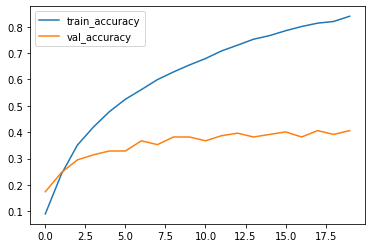

In [24]:
#Generate a accuracy graph
plt.plot(history.epoch, history.history.get("accuracy"), label = "train_accuracy")
plt.plot(history.epoch, history.history.get("val_accuracy"), label = "val_accuracy")
plt.legend()

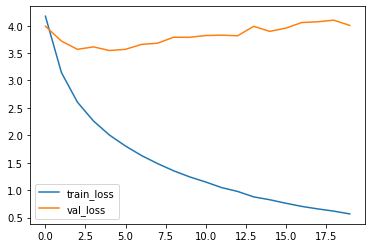

In [25]:
#Generate a loss graph
plt.plot(history.epoch, history.history.get("loss"), label = "train_loss")
plt.plot(history.epoch, history.history.get("val_loss"), label = "val_loss")
plt.legend()

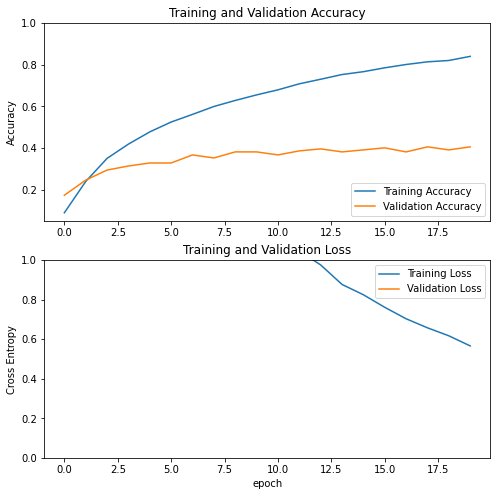

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
model.evaluate(x_test,y_test)

7/7 [==============================] - 0s 30ms/step - loss: 4.0042 - accuracy: 0.4058


[4.004208564758301, 0.4057970941066742]

# Siamese

In [28]:
base_model.trainable = False
model.traiable = False

In [29]:
import PIL
from PIL import Image

from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv2D, MaxPooling2D, Flatten,MaxPool2D
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import inception_resnet_v2


species_txt = "/content/Mydrive/MyDrive/Colab Notebooks/list/species_list.txt"
train_txt = "/content/Mydrive/MyDrive/Colab Notebooks/list/train.txt"
mainPath = "/tmp/"


target_shape = (160, 160)
img_size = 160 # width and height is same

In [30]:
def labelGenerate(): 
    label = []
    i=0
    label_data = open(species_txt,"r") # open txt file name species_list.txt
    for temp in label_data:
        x = temp.split(";")
        label.append([int(x[0]),x[1].strip(),i])## [label number IN string type, label name]
        i += 1
    return label

label = labelGenerate()

In [31]:
def findtxt(check):
    txt = open(train_txt,"r")
    abc = []
    for x in txt:
        temp = x.split(" ")
        if(int(temp[1]) == check):
            abc.append(x)
    return abc

In [32]:
def TrainData():
    anchor = []
    positive = []
    negative = []
    positive2 = []
    ready = []
    for x,y,z in label:
        temp_anchor = []
        abc = findtxt(x)
        for s in abc:
            aa = s.split(" ")
            temp_anchor.append(s)
            anchor.append(aa[0])
        i=1
        for tt in temp_anchor:
            aa = temp_anchor[i].split(" ")
            positive2.append(temp_anchor[i])
            positive.append(aa[0])
            i += 1
            if(i == len(temp_anchor)):
                aa = temp_anchor[0].split(" ")
                positive.append(aa[0])
                positive2.append(temp_anchor[0])
                ready.append(temp_anchor[0])
                break
    i = 0
    for x in positive2:
        temp = x.split(" ")
        temp1 = ready[i].split(" ")
        if(temp[1] == temp1[1]):
            temp1 = ready[i].split(" ")
            negative.append(temp1[0])
        else:
            negative.append(temp1[0])
        if( i + 1 == 100):
            i = 0
        else:
            i+= 1
    return anchor,positive,negative

In [33]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """
    image_string = tf.io.read_file(mainPath + filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    #image = np.array(image) / 255
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """ 

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [34]:
anchor,positive,negative = TrainData()
#anchor_data = DataGenerate(anchor)
#positive_data = DataGenerate(positive)
#negative_data = DataGenerate(negative)

# anchor_data = Transformlabel(anchor_data, label)
# positive_data = Transformlabel(positive_data, label)
# negative_data =Transformlabel(negative_data, label)
image_count = len(anchor)

anchor_data = tf.data.Dataset.from_tensor_slices(anchor)
positive_data = tf.data.Dataset.from_tensor_slices(positive)
negative_data = tf.data.Dataset.from_tensor_slices(negative)

In [35]:
dataset = tf.data.Dataset.zip((anchor_data, positive_data, negative_data))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

#train_dataset = dataset.take(round(image_count * 0.8))
#val_dataset = dataset.skip(round(image_count * 0.8))

#train_dataset = train_dataset.batch(32, drop_remainder=False)
#train_dataset = train_dataset.prefetch(8)

#val_dataset = val_dataset.batch(32, drop_remainder=False)
#val_dataset = val_dataset.prefetch(8)


dataset = dataset.batch(32, drop_remainder=False)

In [36]:
# def visualize(anchor, positive, negative):
#     """Visualize a few triplets from the supplied batches."""

#     def show(ax, image):
#         ax.imshow(image)
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)

#     fig = plt.figure(figsize=(9, 9))

#     axs = fig.subplots(3, 3)
#     for i in range(3):
#         show(axs[i, 0], anchor[i])
#         show(axs[i, 1], positive[i])
#         show(axs[i, 2], negative[i])


# visualize(*list(dataset.take(1).as_numpy_iterator())[0])

In [37]:
flatten = layers.Flatten()(base_model.output)
dense1 = layers.Dense(1024, activation="relu",name="layer1")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(512, activation="relu",name="layer2")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(1024,name="layer3")(dense2)

embedding = Model(base_model.input, output, name="Embedding")

In [38]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1) 
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(mobilenet_v2.preprocess_input(anchor_input)),
    embedding(mobilenet_v2.preprocess_input(positive_input)),
    embedding(mobilenet_v2.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [39]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [40]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001),metrics=['accuracy'])
history = siamese_model.fit(dataset, epochs=10)

Epoch 1/10
149/149 [==============================] - 307s 2s/step - loss: 0.3671
Epoch 2/10
149/149 [==============================] - 311s 2s/step - loss: 0.2004
Epoch 3/10
149/149 [==============================] - 271s 2s/step - loss: 0.1492
Epoch 4/10
149/149 [==============================] - 212s 1s/step - loss: 0.1222
Epoch 5/10
149/149 [==============================] - 210s 1s/step - loss: 0.1049
Epoch 6/10
149/149 [==============================] - 211s 1s/step - loss: 0.0970
Epoch 7/10
149/149 [==============================] - 203s 1s/step - loss: 0.0876
Epoch 8/10
149/149 [==============================] - 205s 1s/step - loss: 0.0879
Epoch 9/10
149/149 [==============================] - 204s 1s/step - loss: 0.0565
Epoch 10/10
149/149 [==============================] - 199s 1s/step - loss: 0.0606


In [41]:
# sample = next(iter(dataset))
# #visualize(*sample)

# anchor, positive, negative = sample

# anchor_embedding, positive_embedding, negative_embedding = (
#     embedding(inception_resnet_v2.preprocess_input(anchor)),
#     embedding(inception_resnet_v2.preprocess_input(positive)),
#     embedding(inception_resnet_v2.preprocess_input(negative)),
# )

In [42]:
# cosine_similarity = metrics.CosineSimilarity()

# positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
# print("Positive similarity:", positive_similarity.numpy())

# negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
# print("Negative similarity", negative_similarity.numpy())

In [43]:
#input_C = tf.keras.layers.Input(shape=(32,))
# x1 = Dense(200, activation='relu')
# x1 = Dense(150, activation='relu')(x1)
import functools
top1_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=1)
top5_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=5)
top1_acc.__name__ = 'top1_acc'
top5_acc.__name__ = 'top5_acc'

predictions_C= Dense(100, activation='softmax')(output)

model_C = Model(inputs=base_model.inputs, outputs=predictions_C)
optimizers = [
    tf.keras.optimizers.Adam(learning_rate=0.00001),
    tf.keras.optimizers.Adam(learning_rate=0.0001),
]
optimizers_and_layers = [(optimizers[0], siamese_model.layers[0]), (optimizers[1], model_C.layers[0])]
optimizersss = tfa.optimizers.MultiOptimizer(optimizers_and_layers)
model_C.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #from_logits true cuz dont have activate softmax
              optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy',top1_acc,top5_acc])
modelchis = model_C.fit(x_train,y_train,shuffle=True,epochs=30,validation_data=(x_test,y_test))
#model_C.compile(loss='mean_squared_error', optimizer='adam')


Epoch 1/30
297/297 [==============================] - 14s 36ms/step - loss: 2.9801 - accuracy: 0.3138 - top1_acc: 0.0063 - top5_acc: 0.0341 - val_loss: 3.6025 - val_accuracy: 0.3140 - val_top1_acc: 0.0000e+00 - val_top5_acc: 0.0000e+00
Epoch 2/30
297/297 [==============================] - 10s 33ms/step - loss: 0.7384 - accuracy: 0.8493 - top1_acc: 0.0067 - top5_acc: 0.0414 - val_loss: 3.5460 - val_accuracy: 0.3140 - val_top1_acc: 0.0000e+00 - val_top5_acc: 0.0000e+00
Epoch 3/30
297/297 [==============================] - 10s 33ms/step - loss: 0.1033 - accuracy: 0.9941 - top1_acc: 0.0067 - top5_acc: 0.0392 - val_loss: 3.3520 - val_accuracy: 0.3671 - val_top1_acc: 0.0000e+00 - val_top5_acc: 0.0000e+00
Epoch 4/30
297/297 [==============================] - 10s 33ms/step - loss: 0.0219 - accuracy: 0.9999 - top1_acc: 0.0067 - top5_acc: 0.0414 - val_loss: 3.3680 - val_accuracy: 0.3671 - val_top1_acc: 0.0000e+00 - val_top5_acc: 0.0000e+00
Epoch 5/30
297/297 [==============================] - 10

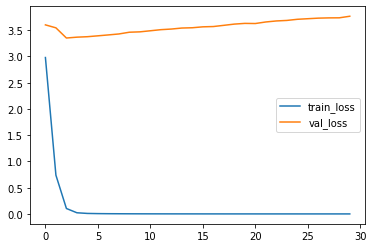

In [44]:
plt.plot(modelchis.epoch, modelchis.history.get("loss"), label = "train_loss")
plt.plot(modelchis.epoch, modelchis.history.get("val_loss"), label = "val_loss")
plt.legend()

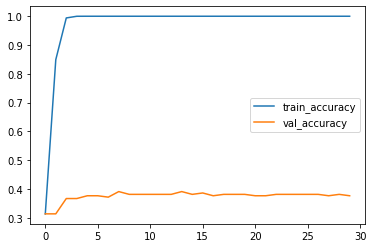

In [45]:
#Generate a accuracy graph
plt.plot(modelchis.epoch, modelchis.history.get("accuracy"), label = "train_accuracy")
plt.plot(modelchis.epoch, modelchis.history.get("val_accuracy"), label = "val_accuracy")
plt.legend()

In [46]:
model_score = model_C.evaluate(x_test,y_test)

print('Loss:', round(model_score[0], 3)*100, '%')
print('Accuracy', round(model_score[1], 3)*100, '%')
print('Top-1 accuracy:', round(model_score[2], 3)*100, '%')
print('Top-5 accuracy:', round(model_score[3],3)*100, '%')

7/7 [==============================] - 0s 32ms/step - loss: 3.7668 - accuracy: 0.3768 - top1_acc: 0.0000e+00 - top5_acc: 0.0000e+00
Loss: 376.7 %
Accuracy 37.7 %
Top-1 accuracy: 0.0 %
Top-5 accuracy: 0.0 %
